Final assignment
===
* Group 3: Elisa Grünauer • Lars Keuter • Dominik Pegler
* Experiment 2: Positive instruction
* Course: Analyzing experimental-psychological data with R (Grüner & Forstinger)
---
## Content

1. Research question  
2. Import libraries  
3. Import data  
4. Data transformation and cleaning  
5. Power analysis  
6. Validity effects  
7. Visualization
---
## 1. Research question

What validity effects can be found for the condition "Positive instruction"?**

* `key_responseTarget.corr_raw` = `answerCorrect`
* `key_responseTarget.rt_raw` = `reactionTime`
* `key_responseTarget.keys_raw` = which key was pressed by the participant

## 2. Import libraries & define functions

In [1]:
# import libraries
library(data.table)
library(ggplot2)
library(lme4) 
library(outliers)
library(ggrepel)
library(emmeans)
library(ggResidpanel)
library(broom)
library(MBESS)
library(nlme)
library(kableExtra)

#library(tidyverse)
#library(viridis)

# default settings ggplot
theme_set(theme_minimal())
update_geom_defaults("bar", list(fill = "steelblue", alpha = 0.8))
update_geom_defaults("point", list(color = "steelblue", alpha = 0.8, size = 2.6))
update_geom_defaults("boxplot", list(fill = "steelblue", alpha = 0.8))

Registered S3 methods overwritten by 'ggplot2':
  method         from 
  [.quosures     rlang
  c.quosures     rlang
  print.quosures rlang
Loading required package: Matrix
Warning message:
“package ‘MBESS’ was built under R version 3.6.3”
Attaching package: ‘nlme’

The following object is masked from ‘package:lme4’:

    lmList

Registered S3 method overwritten by 'rvest':
  method            from
  read_xml.response xml2


### 2.1 Function for APA conform $p$-values

In [2]:
papafy <- function(data, p_column, decimal) {
  data <- as.data.table(data, keep.rownames="model")
  # round bigger p values
  data_temp <- data[, ..p_column]
  names(data_temp) <- "p.value"
  p_string <- rep("", times = length(data_temp$p.value))
  for (i in 1:length(data_temp$p.value)) {
    if (is.na(data_temp$p.value[i])) {
      next
    }
    if (data_temp$p.value[i] < 0.1) {
      p_string[i] <- trimws(format(round(data_temp$p.value[i], 3), nsmall = 3))
      p_string[i] <- substring(p_string[i], 2)
      if (p_string[i] == ".000") {p_string[i] <- "< .001"}
      if (p_string[i] == "A") {p_string[i] <- NA}
    } else if (data_temp$p.value[i] >= 0.1) {
      p_string[i] <- trimws(format(round(data_temp$p.value[i], decimal), nsmall = decimal))
      if (p_string[i] != "1.00") {p_string[i] <- substring(p_string[i], 2)}
      if (p_string[i] == "NA") {p_string[i] <- NA}
    }
  }
  data[[p_column]] <- p_string
  return(data)
}

round_df <- function(df, digits) {
  nums <- vapply(df, is.numeric, FUN.VALUE = logical(1))

  df[,nums] <- round(df[,nums], digits = digits)

  (df)
}

## 3. Import data & define functions

In [3]:
# import data
data_dir <- file.path(getwd(), "final_data")
files <- list.files(data_dir, full.names = TRUE, pattern = "*.txt")

datalist <- lapply(files, function(x)read.table(x, header=T, fileEncoding = "utf8", stringsAsFactors = T, dec=","))
data <- do.call("rbind", datalist)
setDT(data) # Convert data.frame to data.table
cat(nrow(data), "rows")

34560 rows

In [4]:
# get data only for positive instructions
data <- data[instruction == "positive"]

# code timeout as 99
data$answerCorrect <- as.factor(ifelse(is.na(data$key_responseTarget.rt_raw), 99,
                                       ifelse(data$key_responseTarget.corr_raw == 0, 0, 1)))

levels(data$answerCorrect)[levels(data$answerCorrect) == "0"] <- "wrong"
levels(data$answerCorrect)[levels(data$answerCorrect) == "1"] <- "correct"
levels(data$answerCorrect)[levels(data$answerCorrect) == "99"] <- "timeout"

data$reactionTime <- data$key_responseTarget.rt_raw

print(table(data$answerCorrect))


  wrong correct timeout 
    723    7671     246 


Outliers

In [5]:
errorTable <- data[, .(correct = sum(answerCorrect == "correct"),
                        wrong = sum(answerCorrect == "wrong"),
                        timeout = sum(answerCorrect == "timeout"),
                        errorRate = round((sum((answerCorrect != "correct") / 
                                           length(answerCorrect)) * 100), 2)),
                   by = sbj]


print(errorTable[order(-errorRate)])

# test both highest and lowest error rate
grubbs.test(errorTable$errorRate, type = 10, two.sided = FALSE) 
grubbs.test(errorTable$errorRate, type = 10, two.sided = FALSE, opposite = TRUE)

    sbj correct wrong timeout errorRate
 1:   3     341    63      28     21.06
 2:  13     342    73      17     20.83
 3:  20     346    49      37     19.91
 4:  16     352    75       5     18.52
 5:  18     358    59      15     17.13
 6:   2     370    56       6     14.35
 7:  12     376    47       9     12.96
 8:  14     385    28      19     10.88
 9:   1     388    26      18     10.19
10:  11     388    39       5     10.19
11:   8     392    34       6      9.26
12:  17     393    23      16      9.03
13:   4     394    29       9      8.80
14:   7     398    23      11      7.87
15:  19     402    21       9      6.94
16:  10     405    20       7      6.25
17:   6     406    17       9      6.02
18:   9     408    18       6      5.56
19:   5     409    16       7      5.32
20:  15     418     7       7      3.24



	Grubbs test for one outlier

data:  errorTable$errorRate
G = 1.76026, U = 0.82834, p-value = 0.6934
alternative hypothesis: highest value 21.06 is an outlier



	Grubbs test for one outlier

data:  errorTable$errorRate
G = 1.42607, U = 0.88733, p-value = 1
alternative hypothesis: lowest value 3.24 is an outlier


In [6]:
# exclude incorrectly answered trials and timeouts
data_correct <- data[ !(answerCorrect == "incorrect" | answerCorrect == "timeout") ]
wrongAnswers_percentage <-  (nrow(data) - nrow(data_correct)) / nrow(data) 

# exclude trials with rt below 0.15s or above 1s
data_trimmed_correct <- data_correct[! (reactionTime < 0.150 | reactionTime > 1)  ] 
excluded_percentage <- (nrow(data_correct) - nrow(data_trimmed_correct)) / nrow(data_correct) 


data_trimmed_correct_means_sbj <- data_trimmed_correct[, .(meanRT = mean(reactionTime)),
                                                       by = .(cueType, targetValidity, sbj)]

data_validity <-  data_trimmed_correct_means_sbj[,
                        .(validityEffect = meanRT[targetValidity == "invalid"] - 
                            meanRT[targetValidity == "valid"]),
                        by = .(sbj, cueType)]

data_validity[, .(meanVal = mean(validityEffect)), by = .(cueType)]

cueType,meanVal
match,0.063487493
non-match,-0.015819061
inhibition,-0.009700944


In [7]:
data_unique <- unique(data, by = "sbj")

sbj <- data_unique[, .(meanAge = round(mean(age), 2),
                       sdAge = round(sd(age), 2),
                       medianAge = as.double(median(age)),
                       minAge = min(age),
                       maxAge = max(age),
                       n = length(sbj),
                       woman = sum(sex == "w"),
                       man = sum(sex == "m"))]

`r sbj$n` participants (`r sbj$woman` women, `r sbj$man` men) aged between `r sbj$minAge` and `r sbj$maxAge` years (*M*\ =\ `r sbj$meanAge`, *SD*\ =\ `r sbj$sdAge`, *Mdn*\ =\ `r sbj$medianAge`) took part in the experiment. No participant was excluded excluded.

Reliability and Power

In [8]:
trialsPerCell <- data_trimmed_correct[, .N, by = .(sbj, cueType, targetValidity)]

trialsPerCell_results <- trialsPerCell[, .(meanN = mean(N),
                                           sdN = sd(N),
                                           medianN = median(N),
                                           minN = min(N),
                                           maxN = max(N)),
                                       by = .(cueType, targetValidity)]

In [11]:
data_trimmed_correct$condition <- paste(data_trimmed_correct$targetValidity,
                                        data_trimmed_correct$cueType, sep = "_")

# Normalize reaction times------------------------------------------------------

In [12]:
vpn <- NULL
i <- NULL
j <- NULL
data_trimmed_correct$RTnormalized <- 0 


for (i in 1:length(unique(data_trimmed_correct$sbj))) {
  vpn_temp <- unique(data_trimmed_correct$sbj)[i] 
  for (j in 1:length(unique(data_trimmed_correct$condition))) { 
    condition_temp <- unique(data_trimmed_correct$condition)[j] 
    meanRT_temp <- mean(data_trimmed_correct[condition == condition_temp & sbj == vpn_temp]$reactionTime) 
    
    data_trimmed_correct[condition == condition_temp & sbj == vpn_temp]$RTnormalized <- 
      data_trimmed_correct[condition == condition_temp & sbj == vpn_temp]$reactionTime - meanRT_temp 
  }
}

head(data_trimmed_correct[, "RTnormalized"]) 

# add mean to reaction times making them more interpretable
data_trimmed_correct$RTnormalized_real <- data_trimmed_correct$RTnormalized + mean(data_trimmed_correct$reactionTime)

head(data_trimmed_correct[, "RTnormalized_real"])

# setup datatable template------------------------------------------------------

# copy from the real data used for the analysis
dt_template <- copy(data_trimmed_correct[, c("cueType", "targetValidity", "sbj")])

# remove non-existing levels
dt_template$sbj <- factor(dt_template$sbj, levels = (unique(dt_template$sbj)))

# change sbj to 1:end
levels(dt_template$sbj) <- c(1:length(unique(dt_template$sbj)))
levels(dt_template$sbj)

RTnormalized
-0.036448355
0.142947082
-0.134415505
-0.064679412
0.004362913
-0.133852599


RTnormalized_real
0.5214332
0.7008286
0.4234660
0.4932021
0.5622445
0.4240290


[1] "1"  "2"  "3"  "4"  "5"  "6"  "7"  "8"  "9"  "10" "11" "12" "13" "14" "15"
[16] "16" "17" "18" "19" "20"

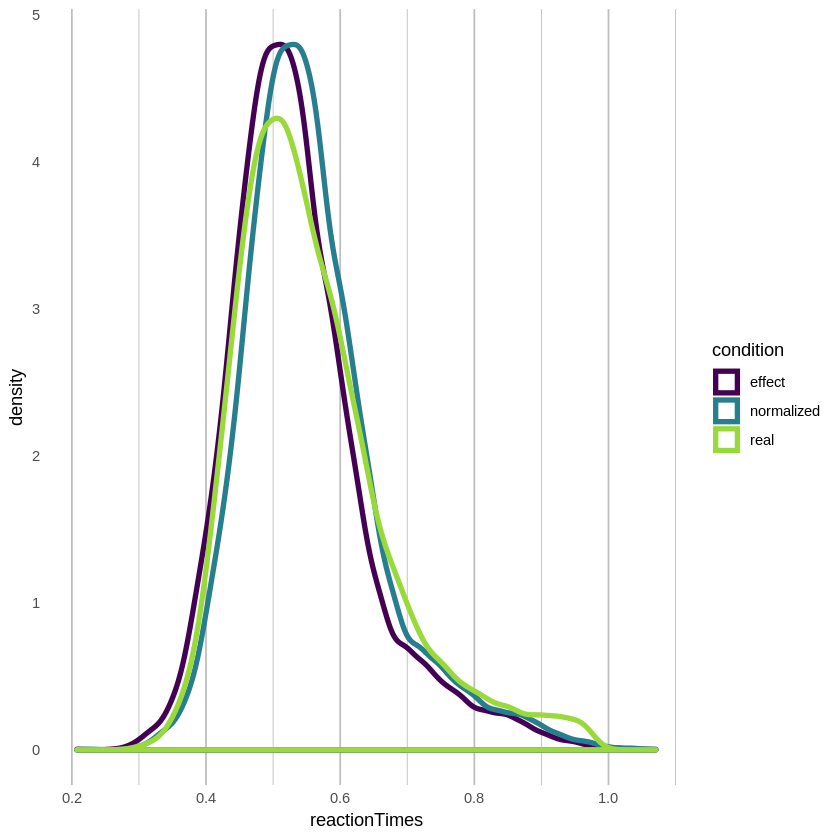

In [13]:
# Plot distributions------------------------------------------------------------

effect <- 0.02 # minimal relevant effect size to simulate
condition <- rep(c("real", "normalized", "effect"),
                 each = length(data_trimmed_correct$RTnormalized_real))
reactionTimes <- c(data_trimmed_correct$reactionTime,
                   data_trimmed_correct$RTnormalized_real,
                   data_trimmed_correct$RTnormalized_real - effect)

rt_distributions <- data.table(conditon = condition, reactionTimes = reactionTimes)

mean_rt <- rt_distributions[, .(meanRT = mean(reactionTimes)), by = .(condition)]

ggplot(rt_distributions, aes(reactionTimes, color = condition)) +
  geom_density(size = 1.5) +
  scale_color_viridis_d(end = 0.85) +
  theme(panel.background = element_blank(),
        panel.grid = element_line(color = "gray"),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.y = element_blank())

In [14]:
#-------------------------------------------------------------------------------

## define simulation function

sim_exp <- function(Nsim, effect, sampleSize, simSampleSize = sampleSize, trialChangeFactor) {

simList <- vector(mode = "list", length = Nsim)
j <- NULL
i <-  NULL
for (j in 1:Nsim) {
  start.time <- Sys.time()
  simData <- copy(dt_template)
  if (simSampleSize < sampleSize) {
    randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
    simData <- simData[simData$sbj %in% randomSbj,]
    levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
    } else if (simSampleSize > sampleSize) {
      sampleSizeIncrease <- simSampleSize - sampleSize
      if (sampleSizeIncrease <= sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simData, simDataAddition)
      } else if (sampleSizeIncrease > sampleSize) {
        simRepetition <- floor(simSampleSize / sampleSize)
        simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
        simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
        simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
        simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
        simDataBase$sbj <- as.factor(simDataBase$sbj_new)
        simDataBase$repetition <- NULL
        simDataBase$sbj_new <- NULL
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
        simDataAddition <- simData[simData$sbj %in% randomSbj,]
        simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
        levels(simDataAddition$sbj) <-
        c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
        simData <- rbind(simDataBase, simDataAddition)
      }
    }

  if (trialChangeFactor < 1) {
    simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
  } else if (trialChangeFactor > 1) {
    simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                     simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
  }

  for (i in 1:simSampleSize) {
    # simulates random interindividual variance
    individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
    RT_var_sd <- 0.015
    RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var5 <- rnorm(1, mean = 0, sd = RT_var_sd)
    RT_var6 <- rnorm(1, mean = 0, sd = RT_var_sd)

    # simulate reaction times per condition
    RT_1 <- sample(data_trimmed_correct$RTnormalized_real - effect + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueType == "match"]),
                   replace = TRUE) + RT_var1
    RT_2 <- sample(data_trimmed_correct$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueType == "non-match"]),
                   replace = TRUE) + RT_var2
    
    RT_3 <- sample(data_trimmed_correct$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "valid" & cueType == "inhibition"]),
                   replace = TRUE) + RT_var3
        
    RT_4 <- sample(data_trimmed_correct$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "match"]),
                   replace = TRUE) + RT_var4
    RT_5 <- sample(data_trimmed_correct$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "non-match"]),
                   replace = TRUE) + RT_var5
    
    RT_6 <- sample(data_trimmed_correct$RTnormalized_real + individualRTvariance,
                   nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition"]),
                   replace = TRUE) + RT_var6

    # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
    simData[sbj == i & targetValidity == "valid" & cueType == "match", reactionTime := RT_1]
    simData[sbj == i & targetValidity == "valid" & cueType == "non-match", reactionTime := RT_2]
    simData[sbj == i & targetValidity == "valid" & cueType == "inhibition", reactionTime := RT_3]
    simData[sbj == i & targetValidity == "invalid" & cueType == "match", reactionTime := RT_4]
    simData[sbj == i & targetValidity == "invalid" & cueType == "non-match", reactionTime := RT_5]
    simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition", reactionTime := RT_6]
  }

  simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
  simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
  end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
  time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
  print(paste("Progress: ", j, "/", Nsim, " (Duration: ", time.taken, " sec)", sep = ""))
}

simData <- rbindlist(simList)

return(simData)

}

In [15]:
# Run simulation ---------------------------------------------------------------

Nsim = 1000
sample_size = length(unique(dt_template$sbj))
simData <- sim_exp(Nsim = Nsim, effect = 0.02, sampleSize = sample_size,
                   simSampleSize = sample_size, trialChangeFactor = 1)

[1] "Progress: 1/1000 (Duration: 0.187503337860107 sec)"
[1] "Progress: 2/1000 (Duration: 0.132095813751221 sec)"
[1] "Progress: 3/1000 (Duration: 0.133330345153809 sec)"
[1] "Progress: 4/1000 (Duration: 0.140153646469116 sec)"
[1] "Progress: 5/1000 (Duration: 0.132745504379272 sec)"
[1] "Progress: 6/1000 (Duration: 0.137288808822632 sec)"
[1] "Progress: 7/1000 (Duration: 0.150248289108276 sec)"
[1] "Progress: 8/1000 (Duration: 0.138536691665649 sec)"
[1] "Progress: 9/1000 (Duration: 0.134958744049072 sec)"
[1] "Progress: 10/1000 (Duration: 0.142129898071289 sec)"
[1] "Progress: 11/1000 (Duration: 0.148119449615479 sec)"
[1] "Progress: 12/1000 (Duration: 0.151074886322021 sec)"
[1] "Progress: 13/1000 (Duration: 0.146475791931152 sec)"
[1] "Progress: 14/1000 (Duration: 0.146629571914673 sec)"
[1] "Progress: 15/1000 (Duration: 0.139594793319702 sec)"
[1] "Progress: 16/1000 (Duration: 0.147081851959229 sec)"
[1] "Progress: 17/1000 (Duration: 0.14510440826416 sec)"
[1] "Progress: 18/1000 (

In [16]:
# Save simulation data ---------------------------------------------------------

saveRDS(simData, "final_data/simData.rds")

sigNiveau = 0.05

#simData <- readRDS("Final Project/simData.rds")

# validity effect for each simulation
simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)), by = .(simNo, targetValidity, cueType, sbj)]

simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] - 
                                             meanRT[targetValidity == "valid"]),
                                       by = .(cueType, sbj, simNo)]

# validity effect mean and sd per simulation
validityEffect_perSim <- simValidityEffect[, .(meanValidityEffect = mean(validityEffect),
                                               sdValidityEffect = sd(validityEffect)),
                                           by = .(simNo, cueType)]


# Compare SD effect of validity effect between real and simulated data ---------

data_trimmed_correct_sd <- data_validity[, .(sdValidityEffect = sd(validityEffect)),
                                 by = .(cueType)]

simData_trimmed_correct_sd <- validityEffect_perSim[, .(meanMean = mean(meanValidityEffect),
                                                       meanSD = mean(sdValidityEffect)),
                                                   by = .(cueType)]

data_trimmed_correct_sd
simData_trimmed_correct_sd

# Get statistical power --------------------------------------------------------
simValidityEffect_results <- simValidityEffect[,
                                 .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                   p.value = t.test(validityEffect, mu = 0)$p.value,
                                   t.stat = t.test(validityEffect, mu = 0)$statistic),
                                 by = .(simNo, cueType)]

powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                          .(EffectFound = .N,
                                            Nsim = max(simValidityEffect_results$simNo),
                                            testPower = .N / max(simValidityEffect_results$simNo)),
                                          by = .(cueType)]

print(powerResults)
powerResults[cueType == "match"]$testPower

cueType,sdValidityEffect
match,0.04043431
non-match,0.01932590
inhibition,0.02179834


cueType,meanMean,meanSD
match,2.005235e-02,0.02881595
non-match,3.214653e-04,0.02879463
inhibition,-5.394213e-05,0.02875590


      cueType EffectFound Nsim testPower
1:      match         824 1000     0.824
2:  non-match          39 1000     0.039
3: inhibition          24 1000     0.024


[1] 0.824

We excluded `r round(wrongAnswers_percentage, 2)`% incorrectly answered trials (including trials where participants did not respond) and from the remaining trials we excluded trials with reaction times below 150\ ms and above 1\ s from all analyses (`r round(excluded_percentage, 2)`%). After these exclusions, the number of valid matching trials ranged from `r trialsPerCell_results[cueType == "match" & targetValidity == "valid"]$minN` to `r trialsPerCell_results[cueType == "match" & targetValidity == "valid"]$maxN` (*M*\ =\ `r round(trialsPerCell_results[cueType == "match" & targetValidity == "valid"]$meanN, 2)`, *SD*\ =\ `r round(trialsPerCell_results[cueType == "match" & targetValidity == "valid"]$sdN, 2)`, *Mdn*\ =\ `r trialsPerCell_results[cueType == "match" & targetValidity == "valid"]$medianN`), and of valid non-matching trials from `r trialsPerCell_results[cueType == "non-match" & targetValidity == "valid"]$minN` to `r trialsPerCell_results[cueType == "non-match" & targetValidity == "valid"]$maxN` (*M*\ =\ `r round(trialsPerCell_results[cueType == "non-match" & targetValidity == "valid"]$meanN, 2)`, *SD*\ =\ `r round(trialsPerCell_results[cueType == "non-match" & targetValidity == "valid"]$sdN, 2)`, *Mdn*\ =\ `r trialsPerCell_results[cueType == "non-match" & targetValidity == "valid"]$medianN`) per participant. A power analysis based on `r Nsim` simulations yielded a power of `r substring(trimws(format(round(powerResults[cueType == "match"]$testPower, 3), nsmall = 3)), 2)` to find a validity effect of 20\ ms in the matching condition with the sample size of `r sample_size` participants.

Plotting {.tabset -}

Reaction times by participant and condition {-}

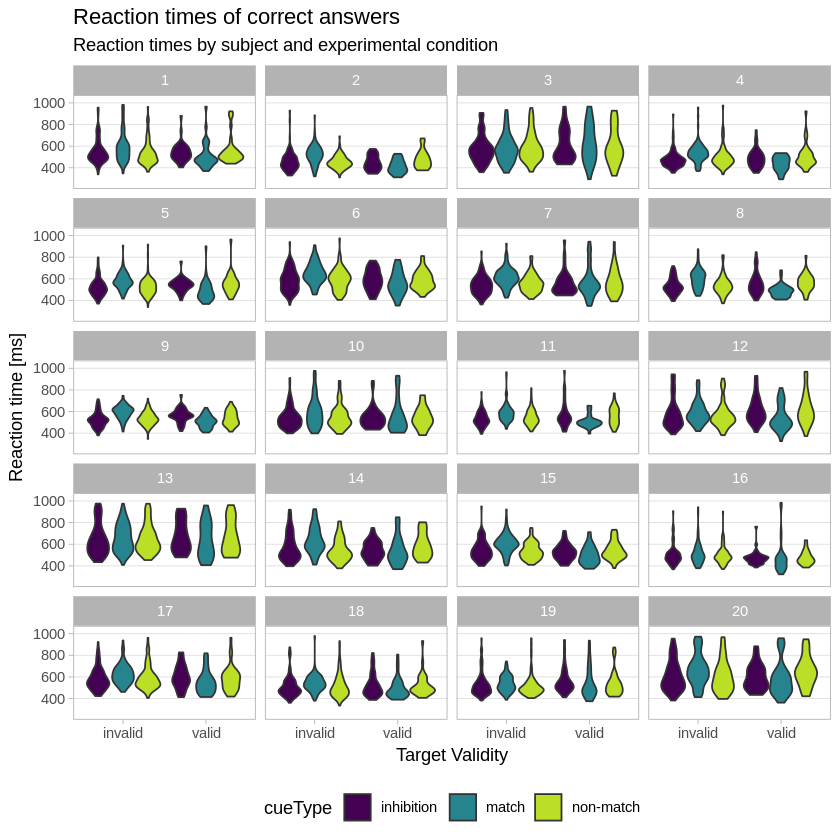

In [17]:
ggplot(data_trimmed_correct, aes(x = targetValidity,
                                 y = reactionTime,
                                 fill = cueType)) +
  geom_violin() +
  
  facet_wrap(~ sbj, ncol=4) + 
  
  labs(title = "Reaction times of correct answers",
       subtitle = "Reaction times by subject and experimental condition",
       x = "Target Validity",
       y = "Reaction time [ms]") +
  
  theme_light() + 
  theme(panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),
        legend.position="bottom") + 
  
  scale_y_continuous(labels = function(x) x * 1000,
                     limits = c(min(data_correct$reactionTime) - 0.05, max(data_correct$reactionTime) + 0.05)) + 
  
  scale_fill_viridis_d(end=0.9)

Mean reaction times and standard errors {-}

Warning message:
“Ignoring unknown parameters: fun”No summary function supplied, defaulting to `mean_se()


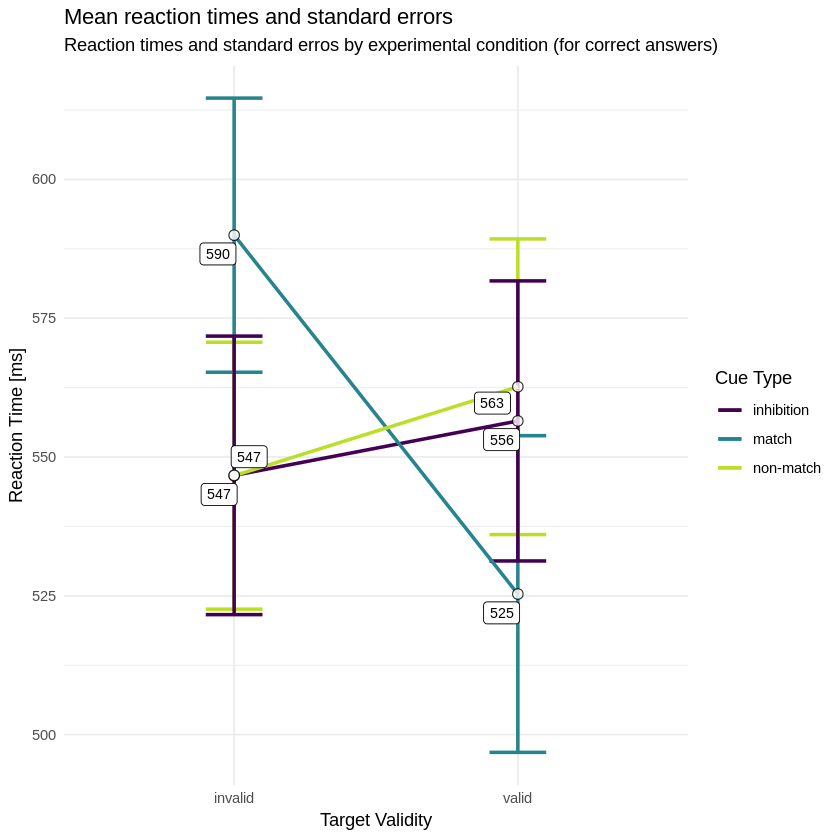

In [18]:
# aggregate data
data_correct_mean_se <- data_trimmed_correct[, .(meanRT = mean(reactionTime),
                                                 seRT = sd(reactionTime) / sqrt(sample_size)),
                                            by = .(cueType, targetValidity)]

ggplot(data_correct_mean_se, aes(x = targetValidity,
                                 y = meanRT,
                                 color = cueType, 
                                 group = cueType)) +
  
       geom_errorbar(aes(ymin = meanRT - seRT,
                         ymax = meanRT + seRT),
                     width = 0.2,
                     size = 1) +
  
       stat_summary(fun = mean,
                    geom = "line",
                    size=1) +
       geom_point(color="black", fill="white", shape=21) + 
  
       geom_label_repel(aes(label = round(meanRT * 1000, 0)),
                        min.segment.length = Inf,
                        color = "black",
                        size = 3) +
       scale_y_continuous(labels = function(x) x * 1000) + 
       
       scale_color_viridis_d(end=0.9) +
       theme_minimal() + 
       labs(title = "Mean reaction times and standard errors",
            subtitle = "Reaction times and standard erros by experimental condition (for correct answers)",
            x = "Target Validity",
            y = "Reaction Time [ms]",
            color = "Cue Type") 

Warning message:
“Ignoring unknown aesthetics: y”Warning message:
“Ignoring unknown parameters: fun”No summary function supplied, defaulting to `mean_se()


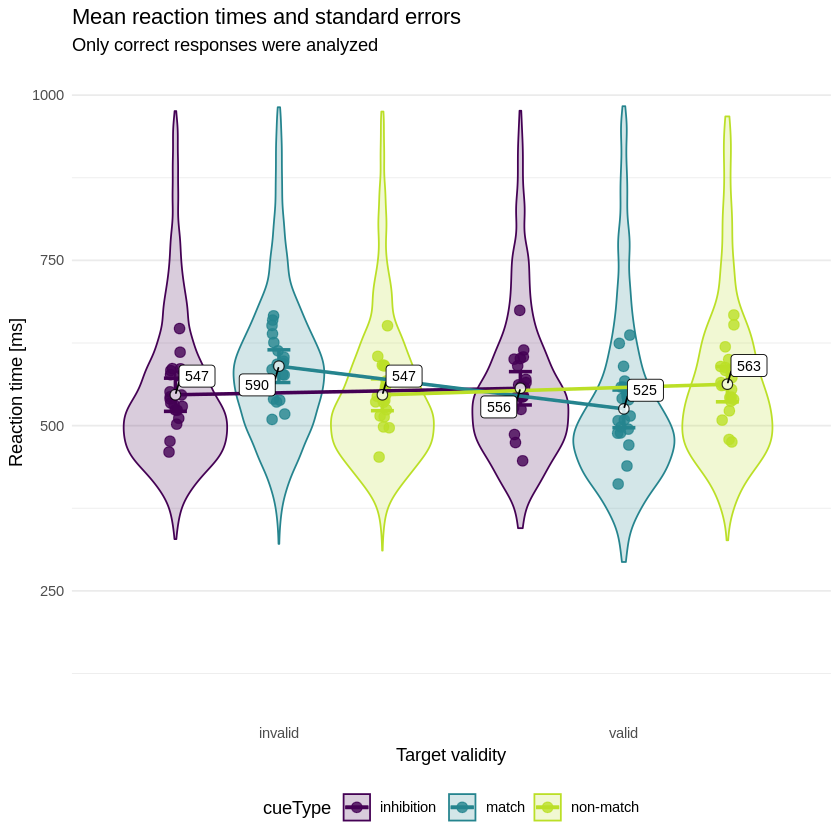

In [19]:
mean_rt_by_subj <- data_trimmed_correct[, .(meanRT = mean(reactionTime)),
                                by = .(sbj, cueType, targetValidity)]
ggplot() +
  
  geom_violin(data_trimmed_correct, mapping = aes(x = targetValidity,
                                          y = reactionTime,
                                          color = cueType,
                                          fill = cueType),
              alpha=0.2, trim=TRUE) +

    geom_jitter(data = mean_rt_by_subj,
                aes(x = targetValidity,
                    y = meanRT,
                    fill = cueType,
                    color = cueType),
                position = position_jitterdodge(jitter.width = 0.1, dodge.width = 0.9)) +
  
    geom_errorbar(data = data_correct_mean_se, 
                  aes(x = targetValidity,
                      y = meanRT,
                      color = cueType,
                      ymin = meanRT - seRT,
                      ymax = meanRT + seRT),
                      size = 1.0, width=0.2, position=position_dodge(0.9)) +
  
    stat_summary(data = data_correct_mean_se,
                 mapping = aes(x = targetValidity, y = meanRT, color=cueType, group=cueType),
                 fun = mean,
                 geom = "line", position=position_dodge(width=0.9), size=1.0) +

    geom_point(data = data_correct_mean_se,
               aes(x = targetValidity,
                   y = meanRT,
                   group=cueType), 
               position=position_dodge(width=0.9),
               color="black", fill="white", shape=21) +
  
    geom_label_repel(data = data_correct_mean_se,
                     aes(x = targetValidity,
                         y = meanRT,
                         group = cueType,
                         label = round(meanRT * 1000, 0)),
                     color = "black", size = 3, seed = 42,
                     position=position_dodge(width=0.9),
                     min.segment.length = 0) +
  
    scale_y_continuous(labels = function(x) x * 1000,
                       limits = c(0.1, 1)) + 
  
    theme_minimal() + 
    theme(panel.grid.minor.x = element_blank(),
          panel.grid.major.x = element_blank(),
          legend.position="bottom") +
  
    labs(title = "Mean reaction times and standard errors",
       subtitle = "Only correct responses were analyzed",
       x = "Target validity",
       y = "Reaction time [ms]") +
  
    scale_fill_viridis_d(end=0.9) +
    scale_color_viridis_d(end=0.9)

 Validity effect {-}

Warning message:
“Removed 7 rows containing missing values (geom_violin).”

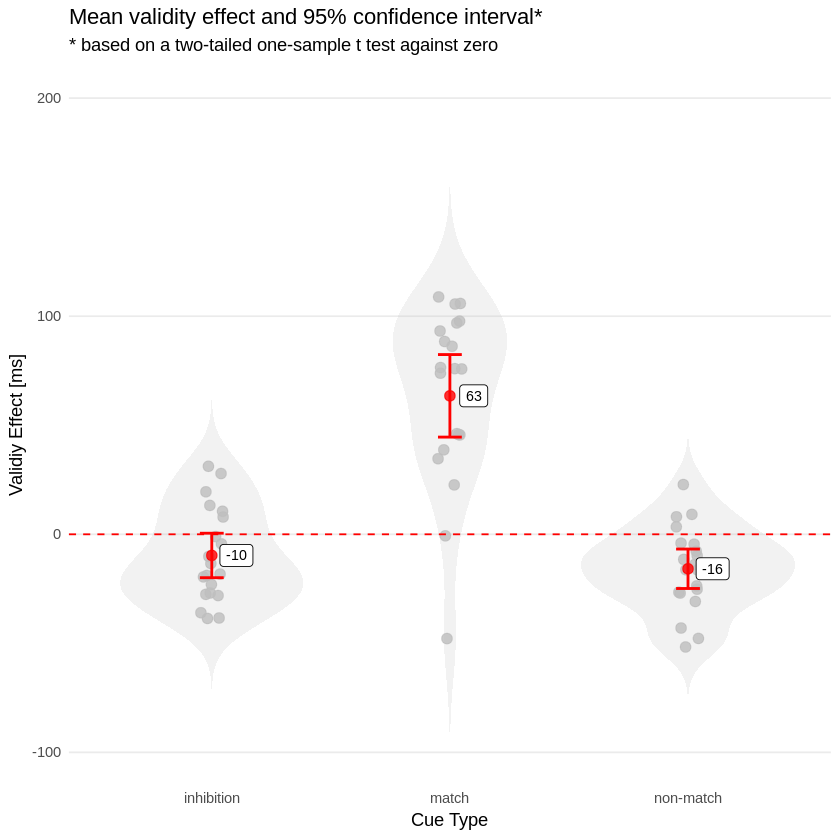

In [20]:
# calc validity effect by subject
validity_effect <- data_trimmed_correct[, .(validityEffect = mean(reactionTime[targetValidity == "invalid"]) - mean(reactionTime[targetValidity == "valid"]) ),
                                        by=.(sbj, cueType)]

validity_effect_mean_se <- validity_effect[, .(mean_effect = mean(validityEffect),
                                               sd_effect = sd(validityEffect)),
                                           by = cueType]

ggplot() +
  
  geom_violin(data = validity_effect,
              aes(x = cueType,
                  y = validityEffect),
              trim = FALSE, fill="grey", color=NA, alpha = 0.2) +
  
  geom_jitter(data = validity_effect,
              aes(x = cueType,
                  y = validityEffect),
              width = 0.05,
              color = "grey", fill="grey") + 
  
  geom_point(data = validity_effect_mean_se,
             aes(x = cueType,
                 y = mean_effect),
             color = "red") +
  
  geom_errorbar(data=validity_effect_mean_se,
                aes(x = cueType,
                    ymin = mean_effect - qt(0.975, df=sample_size-1)*sd_effect/sqrt(sample_size),
                    ymax = mean_effect + qt(0.975, df=sample_size-1)*sd_effect/sqrt(sample_size)),
                    width = 0.1,
                    size = 0.8,
                    color = "red") + 
  
  geom_label_repel(data = validity_effect_mean_se,
             aes(x = cueType,
                 y = mean_effect,
                 label = round(mean_effect * 1000, 0)),
                 color = "black",
                 size = 3,
                 nudge_x = 0.1,
                 seed = 42) +
  
  geom_hline(aes(yintercept = 0),color="red", linetype="dashed") + 
  
  scale_y_continuous(labels = function(x) x * 1000,
                     limits = c(-0.1, 0.2)) + 
  
  theme_minimal() + 
  theme(panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank()) + 
  
  labs(title = "Mean validity effect and 95% confidence interval*",
       subtitle = "* based on a two-tailed one-sample t test against zero",
       x = "Cue Type",
       y = "Validiy Effect [ms]") 

Number of correct trials {-}

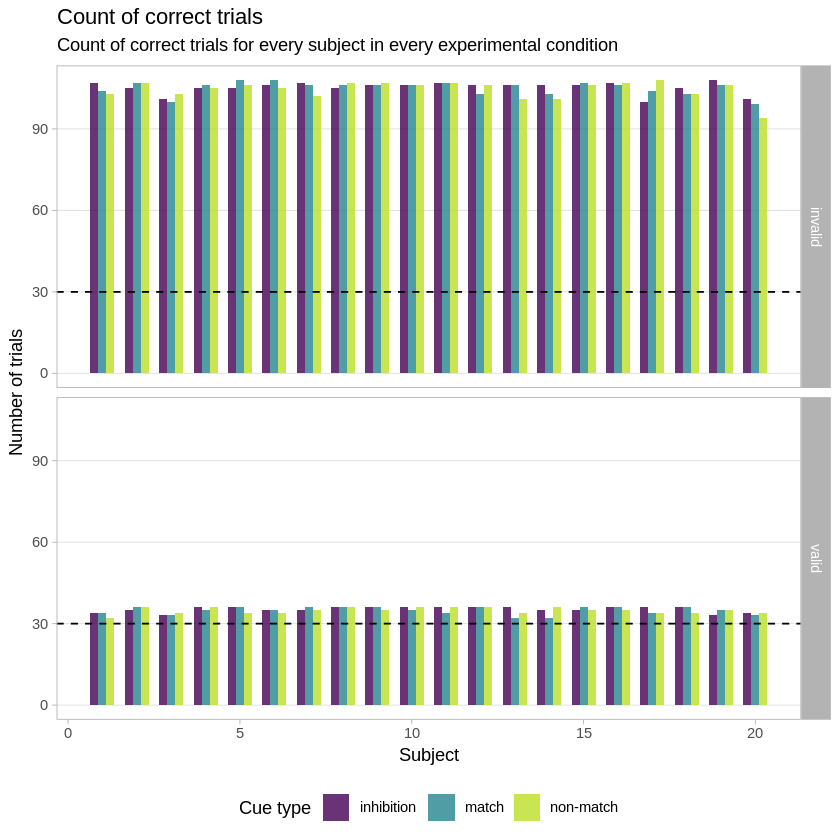

In [21]:
ggplot(data = data_trimmed_correct, aes(x=sbj, fill=cueType)) +
  
  geom_bar(position = position_dodge(), width=0.7) + 
  
  geom_hline(aes(yintercept = 30),color="black", linetype="dashed") + 
  
  facet_wrap(~targetValidity, ncol=1, strip.position="right") +
  
  theme_light() + 
  theme(panel.grid.minor.x = element_blank(),
        panel.grid.minor.y = element_blank(),
        panel.grid.major.x = element_blank(),
        legend.position="bottom") +
  
  scale_fill_viridis_d(end=0.9) +
  
  labs(title = "Count of correct trials",
       subtitle = "Count of correct trials for every subject in every experimental condition",
       x = "Subject",
       y = "Number of trials",
       fill = "Cue type") 

Results {-}

In [22]:
rt.interaction <- lmer(reactionTime ~ cueType * targetValidity + (1 | sbj),
                       data_trimmed_correct, REML = FALSE)

rt.main <- lmer(reactionTime ~ cueType + targetValidity + (1 | sbj),
                    data_trimmed_correct, REML = FALSE)

anova(rt.interaction, rt.main) # interaction model significantely better than main model

# post-hoc analysis
# create interaction model with sbj for correct post-hoc results

# remove non-existing factor level of sjb (important for the gls model later)
data_trimmed_correct$sbj <- factor(data_trimmed_correct$sbj, levels = unique(data_trimmed_correct$sbj))

# using gls() as it allows modelling variable variance across experimental condition and participants
# this im important to get correct standard errors
rt.interaction_sbj <- gls(reactionTime ~ cueType * targetValidity * sbj,
                          data = data_trimmed_correct,
                          weights = varIdent(form = ~ 1 | targetValidity)) # variable variance

# get mean for the interaction model (not including sbj!)
rt.emm <- emmeans(rt.interaction_sbj, ~ cueType * targetValidity,
                  mode = "appx-satterthwaite")

# create contrast across cue type and target validity
rt.contrasts <- rbind(as.data.table(pairs(rt.emm,
                     simple = list("cueType", "targetValidity"))$`simple contrasts for cueType`), # cue type
                     as.data.table(pairs(rt.emm,
                     simple = list("cueType", "targetValidity"))$`simple contrasts for targetValidity`), # target validity
                     use.names = FALSE) # because one column is named differently

,Df,AIC,BIC,logLik,deviance,Chisq,Chi Df,Pr(>Chisq)
rt.main,6,-13878.34,-13836.13,6945.170,-13890.34,NA,NA,NA
rt.interaction,8,-14062.40,-14006.11,7039.198,-14078.40,188.0573,2,1.4584e-41


NOTE: Results may be misleading due to involvement in interactions


In [23]:
# create data table with validity results
# tidy() need the package broom
val.results <- data_validity[, .(shapiroW = tidy(shapiro.test(validityEffect))$statistic,
                                 shapirop = tidy(shapiro.test(validityEffect))$p.value,
                                 mean = tidy(t.test(validityEffect, mu = 0))$estimate,
                                 sd = sd(validityEffect),
                                 tstat = tidy(t.test(validityEffect, mu = 0))$statistic,
                                 p.value = tidy(t.test(validityEffect, mu = 0))$p.value,
                                 wilcoxonp = tidy(wilcox.test(validityEffect,
                                                              mu = 0))$p.value,
                                 df = tidy(t.test(validityEffect, mu = 0))$parameter,
                                 lowerCI = tidy(t.test(validityEffect, mu = 0))$conf.low,
                                 upperCI = tidy(t.test(validityEffect, mu = 0))$conf.high,
                                 d_biased = (mean(validityEffect) / sd(validityEffect)), # effect size biased
                                 n = length(validityEffect)),
                             by = .(cueType)]

# Andere Tests auf Normalverteilung

# ad.test(data_validity[cueType == "match"]$validityEffect)
# cvm.test(data_validity[cueType == "match"]$validityEffect)
# sf.test(data_validity[cueType == "match"]$validityEffect)
# lillie.test(data_validity[cueType == "match"]$validityEffect)
# pearson.test(data_validity[cueType == "match"]$validityEffect)

# add effect size
# ci.sm() needs the package MBESS
val.results[, `:=` (d_unbiased = d_biased * (1 - 3/(4 * (n - 1) - 1)), # hedges correction for effect size
                    esLowerCI = ci.sm(sm = d_biased,
                                      N = n)$Lower.Conf.Limit.Standardized.Mean,
                    esUpperCI = ci.sm(sm = d_biased,
                                      N = n)$Upper.Conf.Limit.Standardized.Mean),
            by = .(cueType)]

[1] "The 0.95 confidence limits for the standardized mean are given as:"
[1] "The 0.95 confidence limits for the standardized mean are given as:"
[1] "The 0.95 confidence limits for the standardized mean are given as:"
[1] "The 0.95 confidence limits for the standardized mean are given as:"
[1] "The 0.95 confidence limits for the standardized mean are given as:"
[1] "The 0.95 confidence limits for the standardized mean are given as:"


We analyzed the reaction time of correct responses using a linear mixed-effect model with the fixed factors target validity and cue type and the per-participant intercept as a random factor. Hierarchical model comparisons showed that the model with the interaction between target validity and cue condition best explained the data. The mean reaction times are shown in Table\ \@ref(tab:tableMeans).

Post-hoc test showed that the interaction is driven by significantly slower reaction time in trials with invalid compared to valid matching cues. We found the reversed pattern with non-matching cues, where reaction times were significantly slower in trials with valid compared to invalid cues. Correspondingly, reaction times were significantly faster in matching compared to non-matching valid cues, see Table\ \@ref(tab:tableContrasts). The mean reaction times including individual means are plotted in Figure\ \@ref(fig:plotReactionTime).


In [24]:
# make contrast table-ready
# infos about tables: http://haozhu233.github.io/kableExtra/awesome_table_in_html.html
# reduce data frame for to table-relevant columns
rt.emm_table <- as.data.table(rt.emm)
# convert seconds in milliseconds
rt.emm_table[, c("emmean", "SE", "lower.CL", "upper.CL")] <- rt.emm_table[, c("emmean", "SE", "lower.CL", "upper.CL")] * 1000

kbl(rt.emm_table,
    digits = c(0, 0, 0, 2, 2, 0, 0),
    caption = "Mean Reaction Times",
    label = "tableMeans",
    col.names = c("Cue Condition", "Target Validity", "*M*", "*SE*", "df", "Lower CI", "Upper CI")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed", "responsive")) %>%
  footnote(general = "*M*, *SE*, and CIs in ms.",
           footnote_as_chunk = TRUE)

rt.contrasts_table <- as.data.table(rt.contrasts)
# convert seconds in milliseconds
rt.contrasts_table[, c("estimate", "SE")] <- rt.contrasts_table[, c("estimate", "SE")] * 1000
rt.contrasts_table <- papafy(rt.contrasts_table, p_column = "p.value", decimal = 3)
kbl(rt.contrasts_table,
    digits = c(0, 0, 0, 2, 0, 2, 0),
    caption = "Comparisons Between Mean Reaction Times",
    label = "tableContrasts",
    col.names = c("Comparisons", "cue type / Target Validity", "*M*", "*SE*", "df", "*t* statstic", "*p* value")) %>%
  kable_styling(bootstrap_options = c("striped", "hover", "condensed", "responsive")) %>%
  footnote(general = "*M* and *SE* in ms.",
           footnote_as_chunk = TRUE)

<table class="table table-striped table-hover table-condensed table-responsive" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
<caption>Mean Reaction Times</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> Cue Condition </th>
   <th style="text-align:left;"> Target Validity </th>
   <th style="text-align:right;"> *M* </th>
   <th style="text-align:right;"> *SE* </th>
   <th style="text-align:right;"> df </th>
   <th style="text-align:right;"> Lower CI </th>
   <th style="text-align:right;"> Upper CI </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> inhibition </td>
   <td style="text-align:left;"> invalid </td>
   <td style="text-align:right;"> 547 </td>
   <td style="text-align:right;"> 2.21 </td>
   <td style="text-align:right;"> 6199.29 </td>
   <td style="text-align:right;"> 543 </td>
   <td style="text-align:right;"> 551 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> match </td>
   <td style="text-align:left;"> invalid </td>


<table class="table table-striped table-hover table-condensed table-responsive" style="margin-left: auto; margin-right: auto;border-bottom: 0;">
<caption>Comparisons Between Mean Reaction Times</caption>
 <thead>
  <tr>
   <th style="text-align:left;"> Comparisons </th>
   <th style="text-align:left;"> cue type / Target Validity </th>
   <th style="text-align:right;"> *M* </th>
   <th style="text-align:right;"> *SE* </th>
   <th style="text-align:right;"> df </th>
   <th style="text-align:right;"> *t* statstic </th>
   <th style="text-align:left;"> *p* value </th>
  </tr>
 </thead>
<tbody>
  <tr>
   <td style="text-align:left;"> inhibition - match </td>
   <td style="text-align:left;"> invalid </td>
   <td style="text-align:right;"> -43 </td>
   <td style="text-align:right;"> 3.13 </td>
   <td style="text-align:right;"> 6199 </td>
   <td style="text-align:right;"> -13.81 </td>
   <td style="text-align:left;"> &lt; .001 </td>
  </tr>
  <tr>
   <td style="text-align:left;"> inhibition - 

## 4. Data transformation and cleaning

In [3]:
names(df)

[1] "cueType"                     "targetValidity"             
 [3] "CueDistractorPosition1"      "cueDistractor2_Position"    
 [5] "cueDistractor3_Position"     "InhibitionDistractor"       
 [7] "Target"                      "TargetColor"                
 [9] "gap_topleft"                 "gap_topright"               
[11] "gap_bottomright"             "gap_bottomleft"             
[13] "corrResp"                    "key_responseTarget.corr_raw"
[15] "key_responseTarget.rt_raw"   "sex"                        
[17] "hand"                        "key_responseTarget.keys_raw"
[19] "sbj"                         "order"                      
[21] "age"                         "instruction"

### 4.1 Limit to positive instructions only (variable `instruction`)

In [4]:
df <- df[df$instruction=="positive", ] # filter
df <- subset(df, select = -c(instruction)) # remove col
nrow_positive <- nrow(df)
cat(nrow_positive, "rows")

8640 rows

### 4.2 Limit to correct responses only (`key_responseTarget.corr_raw`)

In [5]:
df <- df[df$key_responseTarget.corr_raw == 1, ] # filter
df <- subset(df, select = -c(key_responseTarget.corr_raw)) # remove col
nrow_correct <- nrow(df)
cat(nrow_correct, " rows.\n\n", round(100*(1-nrow_correct/nrow_positive), 0), "% of the trials were removed due to incorrect response.", sep="")

7671 rows.

11% of the trials were removed due to incorrect response.

### 4.3 Remove variable `TargetColor` (is always blue)

In [6]:
df <- subset(df, select = -c(TargetColor)) # remove col

### 4.4 Remove redundant variable `key_responseTarget.keys_raw` (same info already in `corrResp`)

In [7]:
df <- subset(df, select = -c(key_responseTarget.keys_raw)) # remove col

### 4.5 Remove variables `age`, `sex` and `hand`

In [8]:
df <- subset(df, select = -c(age, sex, hand)) # remove col

### 4.6 Rename reaction time column to `reactionTime`, convert from factor to numeric and to milliseconds

In [9]:
df <- rename(df, reactionTime = key_responseTarget.rt_raw)
df$reactionTime <- parse_number(as.character(df$reactionTime), locale=locale(decimal_mark = ",")) * 1000 # 1000 -> seconds to milliseconds

### 4.7 Check variables

In [10]:
summary(df)

       cueType     targetValidity CueDistractorPosition1
 inhibition:2575   invalid:5751   topleft :5768         
 match     :2532   valid  :1920   topright:1903         
 non-match :2564                                        
                                                        
                                                        
                                                        
 cueDistractor2_Position cueDistractor3_Position  InhibitionDistractor
 bottomleft :1917        bottomleft:5749         bottomleft :1910     
 bottomright:5754        topright  :1922         bottomright:1921     
                                                 topleft    :1929     
                                                 topright   :1911     
                                                                      
                                                                      
         Target     gap_topleft  gap_topright gap_bottomright gap_bottomleft
 bottomleft :1920   down :2

### 4.8 Removing outliers

In [11]:
aggregate(df$sbj, list(df$sbj), FUN=length)

Group.1,x
1,388
2,370
3,341
4,394
5,409
6,406
7,398
8,392
9,408
10,405


Sbj 3 has the least corr responses (341), but is not really an outlier, I would therefor keep these data. Other option to remove outliers would be by error rate with  a e.g. a (one-sided?) Grubbs test.

### 4.9 Removing unrealistic response times

$\ge 1000 ms$ or $\le 150ms$

In [12]:
df <- df[df$reactionTime<=1000 & df$reactionTime >= 150,]
nrow_clean <- nrow(df)
cat(nrow_clean, " rows.\n\n", round(100*(1-nrow_clean/nrow_correct), 0), "% of the trials were removed due to unrealistic response times.", sep="")

7671 rows.

0% of the trials were removed due to unrealistic response times.

### 4.10 Final data

In [13]:
valid_match <- df[df$targetValidity=="valid" & cueType=="match", ]
valid_match_n <- aggregate(valid_match$sbj, list(valid_match$sbj), FUN=length)

valid_nonmatch <- df[df$targetValidity=="valid" & cueType=="non-match", ]
valid_nonmatch_n <- aggregate(valid_nonmatch$sbj, list(valid_nonmatch$sbj), FUN=length)

cat("After these exclusions, the number of valid matching trials ranged from ",
    min(valid_match_n$x)," to ", max(valid_match_n$x),
    " (M = ", mean(valid_match_n$x),", SD = ", sd(valid_match_n$x), ", Mdn = ", median(valid_match_n$x),
    "),and of valid non-matching trials from ", min(valid_nonmatch_n$x), " to ", max(valid_nonmatch_n$x),
    " (M = ", mean(valid_nonmatch_n$x), ", SD = ", sd(valid_nonmatch_n$x), ", Mdn = ", median(valid_nonmatch_n$x), ") per participant", sep="")

After these exclusions, the number of valid matching trials ranged from 24 to 36 (M = 32.05, SD = 2.981963, Mdn = 32),and of valid non-matching trials from 28 to 35 (M = 31.8, SD = 2.284962, Mdn = 33) per participant

In [14]:
sample_size <- length(unique(df$sbj))
cat("Our sample size is ", sample_size, " participants", sep="")

Our sample size is 20 participants

## 5. Power analysis

### 5.1 Create copy of data table with some additional variables for simulation

In [15]:
df_pwr <- df

df_pwr$condition <- paste(df_pwr$targetValidity, df_pwr$cueType, sep = "_")

# Variablen initiieren
vpn <- NULL
i <- NULL
j <- NULL
df_pwr$RTnormalized <- 0 

for (i in 1:length(unique(df_pwr$sbj))) { # Loop über alle Personen
  vpn_temp <- unique(df_pwr$sbj)[i] 
  for (j in 1:length(unique(df_pwr$condition))) { # Loop über alle Bedingungen pro Person (deshalb genestet [Loop im Loop])
    condition_temp <- unique(df_pwr$condition)[j] 
    meanRT_temp <- mean(df_pwr[condition == condition_temp & sbj == vpn_temp]$reactionTime) # mittlere Reaktionszeit für diese Bedingung ermitteln
    df_pwr[condition == condition_temp & sbj == vpn_temp]$RTnormalized <- 
      df_pwr[condition == condition_temp & sbj == vpn_temp]$reactionTime - meanRT_temp # mittlere Reaktionszeit von den Reaktionszeiten abziehen
  }
}

# Um die Reaktionszeiten wieder realistischer bzwl. leichter interpretierbar zu machen, addieren wir den Mittelwert aller Reaktionzeiten. Die Form der Verteilung bleibt davon unbeeinflusst.
df_pwr$RTnormalized_real <- df_pwr$RTnormalized + mean(df_pwr$reactionTime)

### 5.2 Create template data table

In [16]:
# copy from the real data used for the analysis
dt_template <- copy(df_pwr[, c("cueType", "targetValidity", "sbj")])

# remove non-existing levels
dt_template$sbj <- factor(dt_template$sbj, levels = (unique(dt_template$sbj)))

# change sbj to 1:end
levels(dt_template$sbj) <- c(1:length(unique(dt_template$sbj)))

### 5.3 Script

In [57]:
runSimulation <- function(dt_template, df, Nsim, effect, sampleSize, simSampleSize, trialChangeFactor){
    simList <- vector(mode = "list", length = Nsim)
    j <- NULL
    i <-  NULL
    for (j in 1:Nsim) {
      start.time <- Sys.time()
      simData <- copy(dt_template)
      if (simSampleSize < sampleSize) {
        randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize)
        simData <- simData[simData$sbj %in% randomSbj,]
        levels(simData$sbj)[levels(simData$sbj) %in% randomSbj] <- c(1:simSampleSize)
        } else if (simSampleSize > sampleSize) {
          sampleSizeIncrease <- simSampleSize - sampleSize
          if (sampleSizeIncrease <= sampleSize) {
            randomSbj <- sample(1:length(unique(simData$sbj)), sampleSizeIncrease)
            simDataAddition <- simData[simData$sbj %in% randomSbj,]
            simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
            levels(simDataAddition$sbj) <- c((sampleSize+1):(sampleSize+sampleSizeIncrease))
            simData <- rbind(simData, simDataAddition)
          } else if (sampleSizeIncrease > sampleSize) {
            simRepetition <- floor(simSampleSize / sampleSize)
            simDataBase <- simData[rep(seq_len(nrow(simData)), times = simRepetition), ]
            simDataBase$repetition <- rep(1:simRepetition, each = nrow(simData))
            simDataBase$sbj_new <- as.numeric(simDataBase$sbj)
            simDataBase$sbj_new <- simDataBase$sbj_new + sampleSize * (simDataBase$repetition-1)
            simDataBase$sbj <- as.factor(simDataBase$sbj_new)
            simDataBase$repetition <- NULL
            simDataBase$sbj_new <- NULL
            randomSbj <- sample(1:length(unique(simData$sbj)), simSampleSize %% sampleSize)
            simDataAddition <- simData[simData$sbj %in% randomSbj,]
            simDataAddition$sbj <- factor(simDataAddition$sbj, levels = (unique(simDataAddition$sbj)))
            levels(simDataAddition$sbj) <-
            c((length(unique(simDataBase$sbj))+1):(sampleSize+sampleSizeIncrease))
            simData <- rbind(simDataBase, simDataAddition)
          }
        }

      if (trialChangeFactor < 1) {
        simData <- simData[sample(1:nrow(simData), round(nrow(simData) * trialChangeFactor))]
      } else if (trialChangeFactor > 1) {
        simData <- rbind(simData[rep(seq_len(nrow(simData)), times = floor(trialChangeFactor)), ],
                         simData[sample(1:nrow(simData), round(nrow(simData) * (trialChangeFactor-floor(trialChangeFactor))))])
      }

      for (i in 1:simSampleSize) {
        # simulates random interindividual variance
        individualRTvariance <-  rnorm(1, mean = 0, sd = 0.05)
        RT_var_sd <- 0.015
        RT_var1 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var2 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var3 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var4 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var5 <- rnorm(1, mean = 0, sd = RT_var_sd)
        RT_var6 <- rnorm(1, mean = 0, sd = RT_var_sd)

        # simulate reaction times per condition
        RT_1 <- sample(df$RTnormalized_real - effect + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "match"]),
                       replace = TRUE) + RT_var1
        RT_2 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "non-match"]),
                       replace = TRUE) + RT_var2
        RT_3 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "match"]),
                       replace = TRUE) + RT_var3
        RT_4 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "non-match"]),
                       replace = TRUE) + RT_var4
        RT_5 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "valid" & cueType == "inhibition"]),
                       replace = TRUE) + RT_var5
        RT_6 <- sample(df$RTnormalized_real + individualRTvariance,
                       nrow(simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition"]),
                       replace = TRUE) + RT_var6

        # Zuordnung der simulierten Reaktionszeiten zu den Faktorkombinationen
        simData[sbj == i & targetValidity == "valid" & cueType == "match", reactionTime := RT_1]
        simData[sbj == i & targetValidity == "valid" & cueType == "non-match", reactionTime := RT_2]
        simData[sbj == i & targetValidity == "invalid" & cueType == "match", reactionTime := RT_3]
        simData[sbj == i & targetValidity == "invalid" & cueType == "non-match", reactionTime := RT_4]
        simData[sbj == i & targetValidity == "valid" & cueType == "inhibition", reactionTime := RT_5]
        simData[sbj == i & targetValidity == "invalid" & cueType == "inhibition", reactionTime := RT_6]
      }

      simData[, simNo := j] # ergänzt neue Variable mit der Nummer der Simulation
      simList[[j]] <- copy(simData) # speichert das fertige simulierte Datenframe in die Liste mit den Simulationen
      end.time <- Sys.time() # End-Zeit der Simulation eines Datensatzes
      time.taken <- end.time - start.time # Dauer der Simulation eines Datensatzes
    }

    simData <- rbindlist(simList)

    # Zuletzt vergleichen wir noch die Standardabweichungen der Reaktionzeiten in den Bedingungen der realen und simulierten Daten
    data_trimmed_means_sbj <- df[, .(meanRT = mean(reactionTime)),
                                           by = .(sbj, cueType, targetValidity)]

    data_trimmed_sd <- data_trimmed_means_sbj[, .(SD = sd(meanRT)), by = .(targetValidity, cueType)]

    simData_trimmed_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                         by = .(sbj, targetValidity, cueType, simNo)]

    simData_trimmed_sd_sim <- simData_trimmed_means_sbj[, .(SD = sd(meanRT)),
                                                        by = .(targetValidity, cueType, simNo)]

    simData_trimmed_sd <- simData_trimmed_sd_sim[, .(SD = mean(SD)),
                                                 by = .(targetValidity, cueType)]

    # Berechnung des Validitätseffeks
    simData_means_sbj <- simData[, .(meanRT = mean(reactionTime)),
                                 by = .(simNo, targetValidity, cueType, sbj)]

    simValidityEffect <- simData_means_sbj[, .(validityEffect = meanRT[targetValidity == "invalid"] -
                                                                meanRT[targetValidity == "valid"]),
                                           by = .(cueType, sbj, simNo)]
    # Ergebnisse berechnen
    simValidityEffect_results <- simValidityEffect[,
                                     .(meanValidityEffect = t.test(validityEffect, mu = 0)$estimate,
                                       p.value = t.test(validityEffect, mu = 0)$p.value,
                                       t.stat = t.test(validityEffect, mu = 0)$statistic),
                                     by = .(simNo, cueType)]

    sigNiveau <- 0.05 # Signifikanzniveau definieren

    powerResults <- simValidityEffect_results[t.stat > 0 & p.value < sigNiveau,
                                              .(EffectFound = .N,
                                                Nsim = max(simValidityEffect_results$simNo),
                                                testPower = .N / max(simValidityEffect_results$simNo)),
                                              by = .(cueType)]

    return(powerResults)}

### 5.4 Determine power

In [67]:
condition <- "match"

n_sims <- 1000
effect_est <- 20 # 20 ms validity effect (smallest relevant effect size)
sim_sample_size <- sample_size # sample size for simulation (can be changed!)
trial_change_factor <- 1 # change factor for trial number to increase or decrease trial number

res <- runSimulation(dt_template, df_pwr, n_sims, effect_est, sample_size, sim_sample_size, trial_change_factor)
pwr <- res[res$cueType==condition, ]$testPower

cat(
    "A power analysis based on ", 
    n_sims, " simulations yielded a power of ", 
    pwr, " to find a validity effect of ", 
    effect_est, " ms in the condition positive instruction and ", 
    condition, " with the sample size of ", sample_size, " participants.",
    sep=""
)

A power analysis based on 1000 simulations yielded a power of 0.987 to find a validity effect of 20 ms in the condition positive instruction and match with the sample size of 20 participants.

## 6. Validity effects

### 6.1 Means, SD, n

#### 6.1.1 Valid trials

In [15]:
nrow(df[df$targetValidity=="valid", ])

[1] 1920

In [16]:
mean(df[df$targetValidity=="valid", reactionTime])

[1] 543.5758

In [17]:
sd(df[df$targetValidity=="valid", reactionTime])

[1] 113.2674

#### 6.1.2 Invalid trials

In [18]:
nrow(df[df$targetValidity=="invalid", ])

[1] 5751

In [19]:
mean(df[df$targetValidity=="invalid", reactionTime])

[1] 559.1591

In [20]:
sd(df[df$targetValidity=="invalid", reactionTime])

[1] 104.0098

### 6.3 Validity effects

#### 6.3.1 Overall

In [21]:
mean(df[df$targetValidity=="invalid", reactionTime]) - mean(df[df$targetValidity=="valid", reactionTime])

[1] 15.5833

In [68]:
# p-values (t-test) here

#### 6.3.2 Condition "match"

In [22]:
cT <- "match"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] 71.04696

In [68]:
# p-values (t-test) here

#### 6.3.3 Condition "non-match"

In [23]:
cT <- "non-match"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] -18.43878

In [68]:
# p-values (t-test) here

#### 6.3.4 Condition "inhibition"

In [24]:
cT <- "inhibition"
mean(df[df$targetValidity=="invalid" & cueType==cT, reactionTime]) - mean(df[df$targetValidity=="valid" & cueType==cT, reactionTime])

[1] -5.317096

In [68]:
# p-values (t-test) here

## 7. Visualization

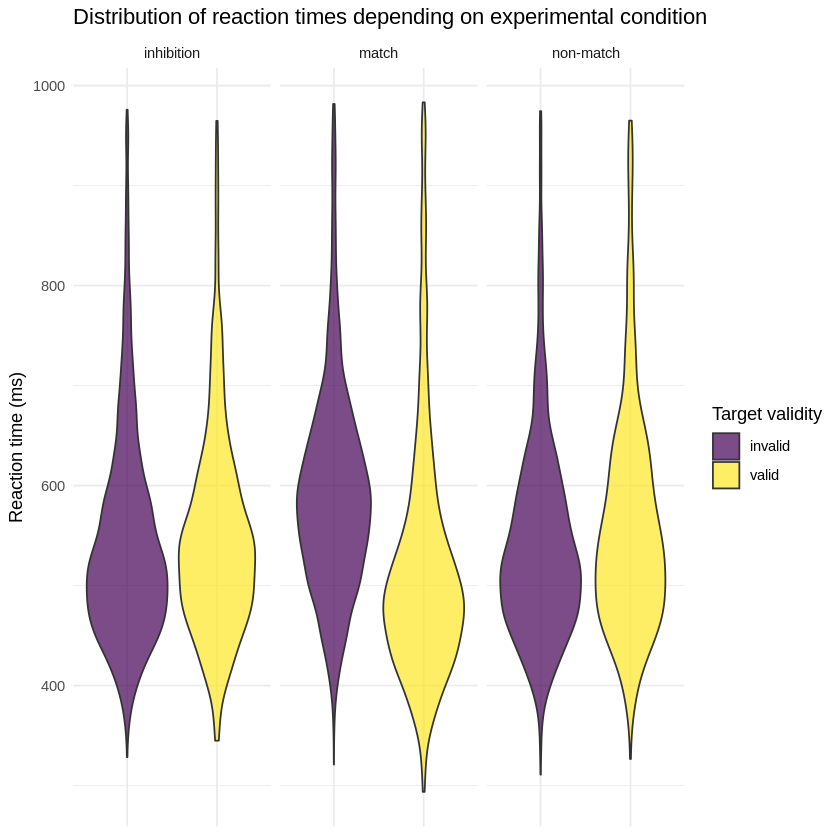

In [25]:
ggplot(df, aes(x=targetValidity, y=reactionTime)) + 
geom_violin(aes(fill=targetValidity), alpha=0.7) +
facet_wrap(~ cueType) +
scale_fill_viridis(discrete=TRUE) +
xlab("") +
ylab("Reaction time (ms)") + 
labs(title="Distribution of reaction times depending on experimental condition", fill = "Target validity") +
theme(axis.title.x=element_blank(),
        axis.text.x=element_blank(),
        axis.ticks.x=element_blank())

Validity effects are only visible in the condition with cue-type "match".